In [80]:
import this

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
from scipy.signal import savgol_filter
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Fonctions utilisées dans ce projet 

In [82]:
## Appliquons la snv à notre array intensities et visualisons 
def snv_spectrum(spectrum):
    mean = np.mean(spectrum)  # Calcul de la moyenne du spectre
    std_dev = np.std(spectrum)  # Calcul de l'écart type du spectre
    snv_spectrum = (spectrum - mean) / std_dev  # Transformation SNV
    return snv_spectrum

def plot_acp_individuals(score, plan_indices, class_labels, explained_variance, individual_names=None):
    """
    Affiche la carte factorielle des individus d'une ACP.

    Args:
        score (array): Les scores (coordonnées des individus) de l'ACP.
        plan_indices (tuple): Les indices des composantes principales à afficher (par exemple, (0, 1) pour le plan 2D).
        class_labels (array): Les classes à utiliser pour colorier les individus.
        explained_variance (array): La variance expliquée par chaque composante principale de l'ACP.
        individual_names (array, facultatif): Les noms des individus (ou labels). Par défaut, None.
    """

    # Extraire les indices des composantes principales à afficher
    component1_index, component2_index = plan_indices

    # Plotter la carte factorielle des individus
    plt.figure(figsize=(16, 9))
    for label in set(class_labels):
        mask = (class_labels == label)
        plt.scatter(score[mask, component1_index], score[mask, component2_index], label=label)

    # Ajouter des labels aux points (en vérifiant si le nom est différent de None)
    if individual_names is not None:
        for i, name in enumerate(individual_names):
            if name is not None:
                plt.annotate(name, (score[i, component1_index], score[i, component2_index]))

    # Afficher la variance expliquée par chaque composante dans le titre du graphique
    plt.title('Carte Factorielle des Individus\n' + '\n'.join([f'Composante {i+1}: {explained_variance[i]:.2%}' for i in plan_indices]))
    plt.xlabel(f'Composante Principale {component1_index + 1}')
    plt.ylabel(f'Composante Principale {component2_index + 1}')
    plt.legend()
    plt.grid(True, axis='both')
    plt.show()

# Exemple d'utilisation de la fonction avec individual_names facultatif
# Vous pouvez fournir ou omettre individual_names en fonction de vos besoins.
# plot_acp_individuals(score, (0, 1), class_labels, explained_variance)
# plot_acp_individuals(score, (0, 1), class_labels, explained_variance, individual_names)



def plot_dendrogram(model, **kwargs):
    """
    Plot a dendrogram based on a hierarchical clustering model.

    Args:
        model (AgglomerativeClustering): The hierarchical clustering model.
        **kwargs: Additional keyword arguments for customizing the dendrogram plot.
    """
    # Create an array to store the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)

    # Calculate counts for each node in the hierarchical tree
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # Leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # Create a linkage matrix containing children, distances, and counts
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the dendrogram using the linkage matrix and custom kwargs
    dendrogram(linkage_matrix, **kwargs)


# Partie 1 : Exercice de reproduction 

## 1 Description du projet 

A partir du jeu de donnees d’analyses des terephtalates utilise dans le cours, vous allez realiser une r egression simple et une regression multiple.

## 2 Dans x tereph.tab selectionnez la quarantieme longueur d’onde du tableau, qu’on notera NIR40, et calculez le coefficient de corr ́elation et les coefficients du mod`ele de r ́egression lineaire de la variable densite en fonction de NIR40.

In [83]:
# importer les données 
x_tereph = pd.read_csv('data/x_tereph.csv')
y_tereph = pd.read_csv('data/y_tereph.csv')

In [84]:
x_tereph.head()

,\,NIR.1,NIR.2,NIR.3,NIR.4,NIR.5,NIR.6,NIR.7,NIR.8,NIR.9,...,NIR.259,NIR.260,NIR.261,NIR.262,NIR.263,NIR.264,NIR.265,NIR.266,NIR.267,NIR.268
0,1,3.0663,3.0861,3.1079,3.0972,2.9979,2.8273,2.6233,2.4039,2.1931,...,0.31308,0.30753,0.30313,0.29980,0.29748,0.29592,0.29489,0.29440,0.29432,0.29443
1,2,3.0675,3.0857,3.0958,3.0692,2.9818,2.8408,2.6760,2.5059,2.3506,...,0.31686,0.31195,0.30806,0.30499,0.30283,0.30149,0.30066,0.30031,0.30030,0.30041
2,3,3.0750,3.0966,3.0916,3.0288,2.8849,2.6885,2.4764,2.2694,2.0824,...,0.34026,0.33545,0.33164,0.32891,0.32703,0.32573,0.32493,0.32464,0.32460,0.32474
3,4,3.0828,3.0973,3.1010,3.0735,2.9913,2.8709,2.7392,2.6102,2.5000,...,0.32389,0.31947,0.31605,0.31332,0.31139,0.31023,0.30955,0.30928,0.30932,0.30947
4,5,3.1029,3.1034,3.0848,3.0228,2.8927,2.7159,2.5384,2.3764,2.2397,...,0.32394,0.31977,0.31649,0.31397,0.31218,0.31108,0.31046,0.31021,0.31026,0.31049


In [85]:
y_tereph.head()

,\,density
0,1,100.00
1,2,80.22
2,3,79.49
3,4,60.80
4,5,59.97


In [86]:
nir_40 = x_tereph['NIR.40'].values
density = y_tereph['density'].values

In [87]:
nir_40

array([1.4571, 1.5239, 1.546 , 1.5877, 1.5931, 1.5724, 1.6892, 1.6537,
       1.6884, 1.645 , 1.7041, 1.6996, 1.7063, 1.7041, 1.7121, 1.7549,
       1.7654, 1.754 , 1.744 , 1.7343, 1.7518])

In [88]:
density

array([100.  ,  80.22,  79.49,  60.8 ,  59.97,  60.48,  40.1 ,  40.  ,
        41.22,  41.16,  20.53,  20.35,  20.33,  20.61,  20.76,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ])

In [89]:
## Calculons la corrélation entre les deux variables 
cor = np.corrcoef(nir_40 , density)
print( " La corrélation entre NIR40 et la densité est ", cor[0,1])

 La corrélation entre NIR40 et la densité est  -0.9801761960280667


 La corrélation entre NIR40 et la densité est  -0.98.
 Il y a une forte corrélation entre les deux variables nous allons alors réaliser un modèle de regression linéaire

In [90]:
# Réalisation de la regression lineaire en utilisant scikit learn
regression_model = LinearRegression()
# Entrainement du modèle 
nir_40 = nir_40.reshape(-1,1)
regression_model.fit(nir_40,y=density)
# prediction 
density_predicted = regression_model.predict(X=nir_40)

# Evaluation du modèle 
rmse = mean_squared_error(y_true=density, y_pred= density_predicted)
r2 = r2_score(y_true = density , y_pred= density_predicted)

# Affichage des valeurs
print("Pente : " ,regression_model.coef_)
print("Ordonnée à l'origine : ", regression_model.intercept_)
print("Racine carrée de l'erreur quadratique moyenne : ", rmse)
print('Sccore R2 : ', r2)


Pente :  [-344.13963868]
Ordonnée à l'origine :  606.9746644059275
Racine carrée de l'erreur quadratique moyenne :  34.907256176224166
Sccore R2 :  0.960745375260051


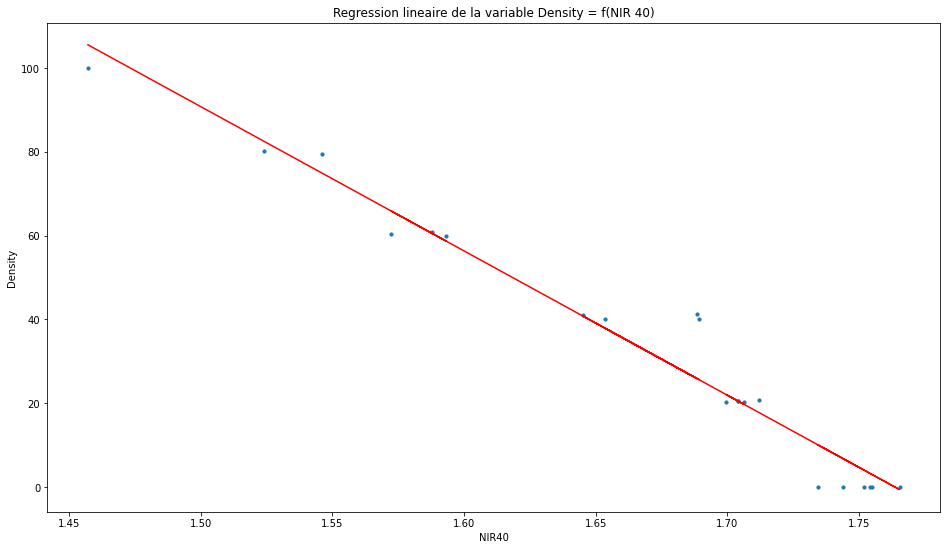

In [91]:
# Tracée des valeurs
# Points de données
plt.figure(figsize=(16,9))
plt.scatter(nir_40, density, s=10)
plt.xlabel('NIR40')
plt.ylabel('Density')
plt.title("Regression lineaire de la variable Density = f(NIR 40)")
# Valeurs prédites
plt.plot(nir_40, density_predicted, color='r')
plt.show()

### Résultat de la regression lineaire simple 
Pente :  [-344.13963868]
Ordonnée à l'origine :  [606.97466441]
Racine carrée de l'erreur quadratique moyenne :  34.907256176224166
Sccore R2 :  0.960745375260051 --> 96% de la variance est expliqué par ce modèle



## 3 Selectionner les variables nir.40 et nir.219 et realiser la régression de la variable densit ́e en fonction de ces deux variables. Donnez le coefficient de corr ́elation multiple au carre R2.


In [92]:
nir_219 = x_tereph["NIR.219"].values
nir_40 = x_tereph['NIR.40'].values

In [93]:
# Réalisation de la regression lineaire en utilisant scikit learn
regression_model = LinearRegression()
# Entrainement du modèle 
nir = np.column_stack((nir_40,nir_219))
regression_model.fit(nir,y=density)
# prediction 
density_predicted = regression_model.predict(X=nir)

# Evaluation du modèle 
rmse = mean_squared_error(y_true=density, y_pred= density_predicted)
r2 = r2_score(y_true = density , y_pred= density_predicted)

# Affichage des valeurs
print("Pente : " ,regression_model.coef_)
print("Ordonnée à l'origine : ", regression_model.intercept_)
print("Racine carrée de l'erreur quadratique moyenne : ", rmse)
print('Sccore R2 : ', r2)


Pente :  [-347.36167309    7.36986092]
Ordonnée à l'origine :  607.2158952354965
Racine carrée de l'erreur quadratique moyenne :  34.86581467867437
Sccore R2 :  0.9607919779041192


#### conclusion 
 Pente :  [-347.36167309    7.36986092]
Ordonnée à l'origine :  607.2158952354965
Racine carrée de l'erreur quadratique moyenne :  34.86581467867437
Sccore R2 :  0.9607919779041192 --> 96% de variance expliqué on peut donc dire que la variable NIR 219 n'a pas apporté d'information supplémentaire 